# 21.2 — Simulating Repairable Systems and Downtime (Monte Carlo)

This notebook is designed to run cleanly in **Google Colab**.

## What you’ll do
1. Get Weibull failure model inputs (β, η) from:
   - **Option A:** Fit from `Failure_Events_CLEAR_Enhanced.xlsx` (event log → derived intervals)
   - **Option B:** Manual input (use your fitted values)
2. Define repair time uncertainty (TTR distribution)
3. Simulate a **repairable** fleet over an operating horizon:
   - multiple failures per unit
   - downtime accumulation
   - availability calculation
4. Produce **book-ready figures** saved to `figures/`:
   - downtime distribution (histogram)
   - availability distribution
   - failure count distribution
   - example timeline (one simulated run)

> Dataset is optional. If you already know β and η, set `USE_DATASET_FIT=False`.


## 0) Install dependencies (Colab)

In [4]:
# If running in Google Colab, uncomment and run once:
!pip install "numpy<2.0"
!pip -q install reliability openpyxl

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.2
    Uninstalling numpy-2.4.2:
      Successfully uninstalled numpy-2.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
reliability 0.9.0 requires numpy>=2.2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires

  ERROR: Operation cancelled by user
^C


## 1) Upload dataset (optional, Colab)

In [2]:
# If you want to fit β and η from the dataset, upload it here:
from google.colab import files
uploaded = files.upload()

Saving Failure_Events_CLEAR_Enhanced.xlsx to Failure_Events_CLEAR_Enhanced.xlsx


## 2) Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reliability.Fitters import Fit_Weibull_2P

## 3) Weibull inputs (β, η): fit from dataset or manual

- If `USE_DATASET_FIT=True`, we fit Weibull from derived failure intervals.
- Otherwise, we use the manual values.

> Engineering note: these Weibull parameters should represent the population you are simulating (e.g., one asset type).


In [2]:
USE_DATASET_FIT = True

# Manual Weibull parameters (used if USE_DATASET_FIT = False)
BETA_MANUAL = 1.22
ETA_MANUAL  = 5910.9  # hours

In [3]:
DATA_FILE = "Failure_Events_CLEAR_Enhanced.xlsx"

if USE_DATASET_FIT:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(
            f"{DATA_FILE} not found. Upload it first (Section 1) or set USE_DATASET_FIT = False."
        )

    df = pd.read_excel(DATA_FILE)

    required_cols = ["Asset_ID", "Event_Type", "Failure_Start"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df["Failure_Start"] = pd.to_datetime(df["Failure_Start"], errors="coerce")
    df = df.dropna(subset=["Failure_Start"]).copy()

    FAILURE_EVENTS = {"FAILURE", "TRIP"}  # edit if needed

    df_fail = df[df["Event_Type"].astype(str).str.upper().isin(FAILURE_EVENTS)].copy()
    df_fail["Event_Type"] = df_fail["Event_Type"].astype(str).str.upper()

    df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])
    df_fail["TTF_hours"] = df_fail.groupby("Asset_ID")["Failure_Start"].diff().dt.total_seconds() / 3600.0

    intervals = df_fail["TTF_hours"].dropna()
    intervals = intervals[intervals > 0]

    print("Derived failure intervals (hours):", len(intervals))

    # Right-censoring (recommended, but may be 0 depending on dataset window)
    OBS_END = df["Failure_Start"].max()
    last_fail = df_fail.groupby("Asset_ID")["Failure_Start"].max()
    right_censored = (OBS_END - last_fail).dt.total_seconds() / 3600.0
    right_censored = right_censored[right_censored > 0]

    fit = Fit_Weibull_2P(
        failures=intervals.values,
        right_censored=right_censored.values,
        show_probability_plot=False
    )

    beta = float(fit.beta)
    eta  = float(fit.alpha)

    print(f"Fitted β (shape): {beta:.4f}")
    print(f"Fitted η (scale): {eta:.2f} hours")
else:
    beta = float(BETA_MANUAL)
    eta  = float(ETA_MANUAL)
    print(f"Manual β (shape): {beta:.4f}")
    print(f"Manual η (scale): {eta:.2f} hours")

Derived failure intervals (hours): 113
Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 113/48 (29.81366% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         7977.34         628.256   6836.31   9308.82
     Beta         1.19621        0.088274   1.03512   1.38236 

Goodness of fit    Value
 Log-likelihood -1125.26
           AICc  2254.59
            BIC  2260.67
             AD  5.04371 

Fitted β (shape): 1.1962
Fitted η (scale): 7977.34 hours


## 4) Define repair time (TTR) distribution

Repair times are often **right-skewed**, so Lognormal is a practical default.

Choose:
- `TTR_DIST = "lognormal"` (default)
- `TTR_DIST = "normal"` (truncated at >0)
- `TTR_DIST = "fixed"` (simple demo)

If you have CMMS repair durations, you can replace this with an empirical distribution.


In [4]:
# === EDIT THESE ===
TTR_DIST = "lognormal"   # "lognormal", "normal", "fixed"

# If lognormal/normal: specify mean and stdev (hours)
TTR_MEAN = 8.0     # average repair duration in hours
TTR_STD  = 4.0     # variability (hours)

# If fixed:
TTR_FIXED = 8.0

def sample_ttr(rng, size=1):
    if TTR_DIST == "fixed":
        return np.full(size, TTR_FIXED, dtype=float)

    if TTR_DIST == "normal":
        x = rng.normal(TTR_MEAN, TTR_STD, size=size)
        return np.maximum(x, 0.01)

    if TTR_DIST == "lognormal":
        mean = max(TTR_MEAN, 0.01)
        std  = max(TTR_STD, 0.01)
        var = std**2
        sigma2 = np.log(1 + var/(mean**2))
        sigma = np.sqrt(sigma2)
        mu = np.log(mean) - 0.5*sigma2
        return rng.lognormal(mean=mu, sigma=sigma, size=size)

    raise ValueError("Unknown TTR_DIST")

## 5) Simulation design (repairable fleet)

Each unit alternates between:
- UP time (sampled from Weibull)
- DOWN time (sampled from repair distribution)

We repeat the cycle until reaching the horizon `T_HORIZON`.

### Fleet metrics per simulation run
- total downtime across all units (hours)
- total failures (repairs)
- fleet-average availability


In [5]:
# === EDIT THESE FOR YOUR SCENARIO ===
N_UNITS    = 10         # fleet size
T_HORIZON  = 8760.0     # hours (e.g., 1 year)
N_SIM      = 10000      # Monte Carlo iterations
SEED       = 123        # reproducibility

## 6) Core simulation function

In [6]:
def simulate_one_unit_repairable(rng, beta, eta, horizon):
    """Simulate one repairable unit over the horizon.
    Returns: (downtime_hours, failures_count, timeline_segments)
    segments: list of (start, end, state) where state in {"UP","DOWN"}
    """
    t = 0.0
    downtime = 0.0
    failures = 0
    segments = []

    while t < horizon:
        # Uptime until next failure
        ttf = eta * rng.weibull(beta)
        up_end = min(t + ttf, horizon)
        if up_end > t:
            segments.append((t, up_end, "UP"))
        t = up_end

        if t >= horizon:
            break

        # Failure -> downtime for repair
        failures += 1
        ttr = float(sample_ttr(rng, size=1)[0])
        down_end = min(t + ttr, horizon)
        downtime += max(0.0, down_end - t)
        if down_end > t:
            segments.append((t, down_end, "DOWN"))
        t = down_end

    return downtime, failures, segments

## 7) Run Monte Carlo (fleet)

In [7]:
rng = np.random.default_rng(SEED)

fleet_downtime = np.empty(N_SIM, dtype=float)
fleet_failures = np.empty(N_SIM, dtype=int)
fleet_avail    = np.empty(N_SIM, dtype=float)

example_segments = None  # timeline for unit 1 in iteration 1

for i in range(N_SIM):
    total_down = 0.0
    total_fail = 0

    for u in range(N_UNITS):
        down, fails, seg = simulate_one_unit_repairable(rng, beta, eta, T_HORIZON)
        total_down += down
        total_fail += fails
        if i == 0 and u == 0:
            example_segments = seg

    fleet_downtime[i] = total_down
    fleet_failures[i] = total_fail
    fleet_avail[i] = (N_UNITS * T_HORIZON - total_down) / (N_UNITS * T_HORIZON)

float(fleet_downtime.mean()), float(fleet_avail.mean()), int(fleet_failures.mean())

(82.32977133567168, 0.9990601624276751, 10)

## 8) Summarize metrics (mean + percentiles)

In [8]:
def summarize(x):
    return {
        "mean": float(np.mean(x)),
        "p50": float(np.percentile(x, 50)),
        "p90": float(np.percentile(x, 90)),
        "p95": float(np.percentile(x, 95)),
        "p99": float(np.percentile(x, 99)),
    }

dow = summarize(fleet_downtime)
av  = summarize(fleet_avail)
fc  = summarize(fleet_failures)

print("=== INPUTS ===")
print(f"Weibull: β={beta:.3f}, η={eta:.1f} hours")
print(f"TTR: {TTR_DIST} (mean≈{TTR_MEAN}h, std≈{TTR_STD}h; fixed={TTR_FIXED}h)")
print(f"Fleet: N_UNITS={N_UNITS}, Horizon={T_HORIZON:.0f}h, N_SIM={N_SIM}")
print()
print("=== OUTPUTS (fleet-level) ===")
print(f"Total downtime (h): mean={dow['mean']:.2f}, P90={dow['p90']:.2f}, P95={dow['p95']:.2f}, P99={dow['p99']:.2f}")
print(f"Availability: mean={av['mean']:.4f}, P90={av['p90']:.4f}, P95={av['p95']:.4f}, P99={av['p99']:.4f}")
print(f"Failures (repairs): mean={fc['mean']:.2f}, P90={fc['p90']:.0f}, P95={fc['p95']:.0f}, P99={fc['p99']:.0f}")

=== INPUTS ===
Weibull: β=1.196, η=7977.3 hours
TTR: lognormal (mean≈8.0h, std≈4.0h; fixed=8.0h)
Fleet: N_UNITS=10, Horizon=8760h, N_SIM=10000

=== OUTPUTS (fleet-level) ===
Total downtime (h): mean=82.33, P90=118.65, P95=129.96, P99=153.39
Availability: mean=0.9991, P90=0.9994, P95=0.9995, P99=0.9997
Failures (repairs): mean=10.29, P90=14, P95=15, P99=18


## 9) Plot and save figures (300 DPI)

In [9]:
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name: str):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

### 9.1 Downtime distribution

Saved: figures/MC_21_2_fleet_downtime_hist.png


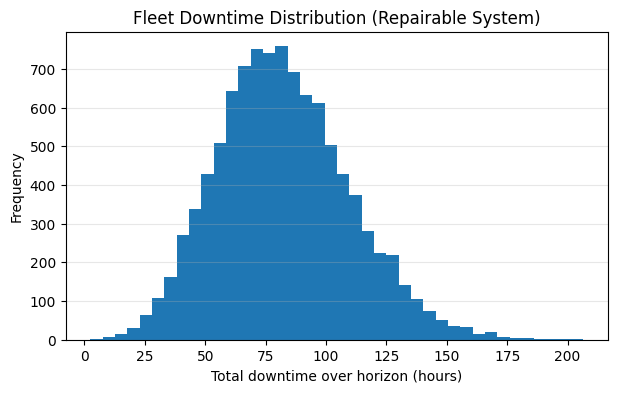

In [10]:
plt.figure(figsize=(7,4))
plt.hist(fleet_downtime, bins=40)
plt.xlabel("Total downtime over horizon (hours)")
plt.ylabel("Frequency")
plt.title("Fleet Downtime Distribution (Repairable System)")
plt.grid(True, axis="y", alpha=0.3)
savefig("MC_21_2_fleet_downtime_hist.png")
plt.show()

### 9.2 Availability distribution

Saved: figures/MC_21_2_fleet_availability_hist.png


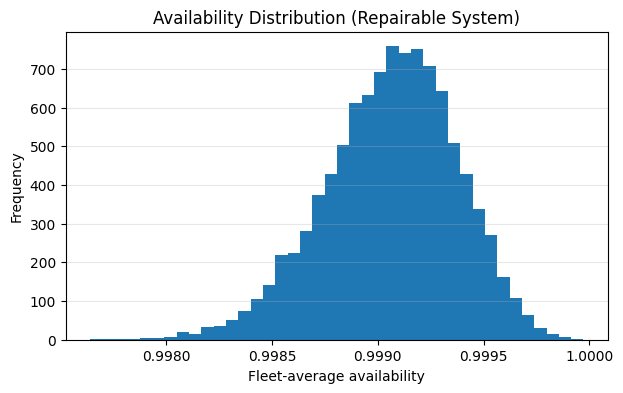

In [11]:
plt.figure(figsize=(7,4))
plt.hist(fleet_avail, bins=40)
plt.xlabel("Fleet-average availability")
plt.ylabel("Frequency")
plt.title("Availability Distribution (Repairable System)")
plt.grid(True, axis="y", alpha=0.3)
savefig("MC_21_2_fleet_availability_hist.png")
plt.show()

### 9.3 Failure count distribution

Saved: figures/MC_21_2_fleet_failure_count_hist.png


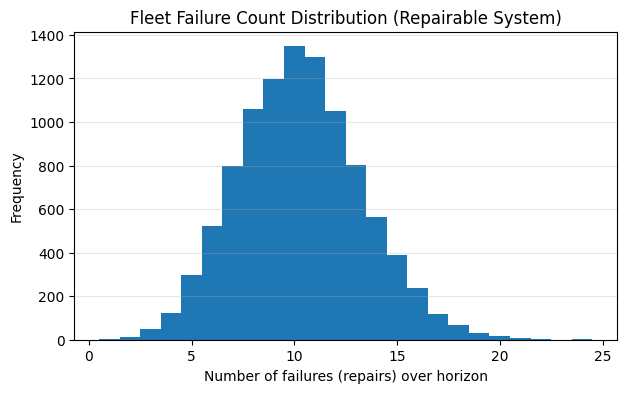

In [12]:
plt.figure(figsize=(7,4))
bins = np.arange(fleet_failures.min(), fleet_failures.max()+2) - 0.5
plt.hist(fleet_failures, bins=bins)
plt.xlabel("Number of failures (repairs) over horizon")
plt.ylabel("Frequency")
plt.title("Fleet Failure Count Distribution (Repairable System)")
plt.grid(True, axis="y", alpha=0.3)
savefig("MC_21_2_fleet_failure_count_hist.png")
plt.show()

### 9.4 Example timeline (one unit, one run)

Saved: figures/MC_21_2_example_timeline.png


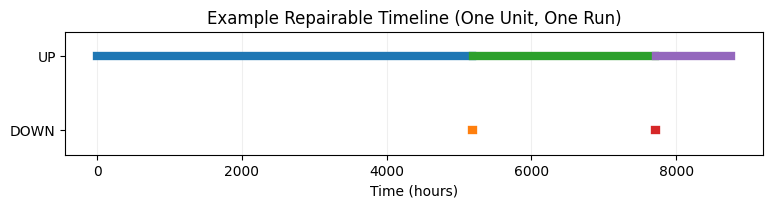

In [13]:
if example_segments is None:
    raise RuntimeError("Example timeline not captured.")

plt.figure(figsize=(9,1.6))
for (s, e, st) in example_segments:
    y = 1.0 if st == "UP" else 0.4
    plt.plot([s, e], [y, y], linewidth=6)

plt.yticks([0.4, 1.0], ["DOWN", "UP"])
plt.xlabel("Time (hours)")
plt.title("Example Repairable Timeline (One Unit, One Run)")
plt.ylim(0.2, 1.2)
plt.grid(True, axis="x", alpha=0.2)
savefig("MC_21_2_example_timeline.png")
plt.show()

## 10) Export a results summary CSV for your repo

In [ ]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

summary = {
    "beta": beta,
    "eta_hours": eta,
    "ttr_dist": TTR_DIST,
    "ttr_mean_hours": TTR_MEAN,
    "ttr_std_hours": TTR_STD,
    "ttr_fixed_hours": TTR_FIXED,
    "n_units": N_UNITS,
    "horizon_hours": T_HORIZON,
    "n_sim": N_SIM,
    "downtime_mean": dow["mean"],
    "downtime_p90": dow["p90"],
    "downtime_p95": dow["p95"],
    "downtime_p99": dow["p99"],
    "availability_mean": av["mean"],
    "availability_p90": av["p90"],
    "availability_p95": av["p95"],
    "availability_p99": av["p99"],
    "failures_mean": fc["mean"],
    "failures_p90": fc["p90"],
    "failures_p95": fc["p95"],
    "failures_p99": fc["p99"],
}

summary_df = pd.DataFrame([summary])
out_csv = os.path.join(OUT_DIR, "MC_21_2_repairable_system_summary.csv")
summary_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

summary_df

## 11) Copy-ready interpretation template (for your manuscript)

In [ ]:
print(
f"""Copy-ready interpretation (edit as needed):

Using Weibull failure behavior (β={beta:.3f}, η={eta:.1f} hours) and a repair-time model ({TTR_DIST}, mean≈{TTR_MEAN:.1f}h, std≈{TTR_STD:.1f}h),
we simulated {N_SIM} Monte Carlo futures for a fleet of {N_UNITS} repairable units over a horizon of {T_HORIZON:.0f} hours.

Total fleet downtime over the horizon has mean {dow['mean']:.1f} hours, with tail-risk exposure P90={dow['p90']:.1f}, P95={dow['p95']:.1f},
and P99={dow['p99']:.1f}. The resulting fleet-average availability has mean {av['mean']:.4f}, with P95={av['p95']:.4f}.
The fleet experiences an average of {fc['mean']:.1f} failures (repairs) during the horizon (P95={fc['p95']:.0f}).

These distributions quantify not only expected performance but also the high-percentile risk that drives contingency planning for staffing,
spare staging, and redundancy decisions.

Figures: MC_21_2_fleet_downtime_hist.png, MC_21_2_fleet_availability_hist.png, MC_21_2_fleet_failure_count_hist.png, MC_21_2_example_timeline.png
"""
)

## 12) (Colab) Download figures/outputs (optional)

In [ ]:
# Uncomment in Colab:
# import shutil
# from google.colab import files
# shutil.make_archive("MC_21_2_figures", "zip", "figures")
# shutil.make_archive("MC_21_2_outputs", "zip", "outputs")
# files.download("MC_21_2_figures.zip")
# files.download("MC_21_2_outputs.zip")